In [31]:
import scipy
import networkx as nx
import pybind11
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import shapely 
import os
import sys
from shapely import wkt
from shapely.geometry import Point
import random
from geopy.distance import geodesic
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import re

In [2]:
os.chdir('/home/xuyuan/Desktop/2024 summer/real estate paper/writing/RealEstateBrokerage/network_estimation')
import network_formulation
os.chdir('/home/xuyuan/Desktop/2024 summer/real estate paper/oritignal cleaning/RealEstateBrokerage')

We need modification of the weight matrix using either the z-normalization or using the max-min normalization

In [3]:
data = pd.read_stata('template.dta')

In [4]:
codebook = {
    1: 'Beijing',
    2: 'Chengdu',
    3: 'Chongqing',
    4: 'Guangzhou',
    5: 'Hangzhou',
    6: 'Nanjing',
    7: 'Shanghai',
    8: 'Shenzhen',
    9: 'Tianjin',
    10: 'Wuhan'
}

data['city_id'] = data['city_id'].map(codebook)

In [5]:
map_data = data[(data['city_id'] == 'Beijing') & (data['year'] == 2019)]
map_data = gpd.GeoDataFrame(map_data, geometry = map_data.geometry.apply(wkt.loads))
df = pd.read_csv("classifying brokerages/processed/19_北京市.csv")
map_data['longitude'] = map_data['geometry'].apply(lambda point: point.x)
map_data['latitude'] = map_data['geometry'].apply(lambda point: point.y)

In [6]:
print(np.max(map_data['number']))
print(np.min(map_data['number']))

196
1


In [7]:
percentiles = np.arange(10, 91, 10)  # This will create an array from 10 to 90 inclusive
percentile_values = np.percentile(map_data['number'], percentiles).astype(float)  # Ensure they are float
np.set_printoptions(suppress=True)
# Create a DataFrame to display the results
percentile_values

array([ 1.,  2.,  3.,  4.,  6.,  9., 12., 18., 29.])

In [8]:
# the effect should be the number in the data
effects = map_data['number'].values
stores = df[['gpsx', 'gpsy']].values.tolist()
communities = map_data[['longitude', 'latitude']].values.tolist()


```
pip install pybind11

python3-config --cflags

pybind11-config --includes

cd /home/xuyuan/Desktop/2024\ summer/real\ estate\ paper/writing/RealEstateBrokerage/network_estimation

g++ -O3 -shared -std=c++11 -fPIC -I/usr/include/python3.10 -I/home/xuyuan/.local/lib/python3.10/site-packages/pybind11/include -o network_formulation.so network_formulation.cpp
```

In [9]:
within_distance_meters = 410.0 # this is what we find in the RD design
# Perform network formation
network, edges = network_formulation.network_formation(stores, communities, effects, within_distance_meters)

In [10]:
df_edges = pd.DataFrame(edges, columns=["store_id_1", "store_id_2", "effect"])
df_network = []
for i, comm_effects in enumerate(network):
    for comm, effect in comm_effects:
        df_network.append((i, comm, effect))
df_network = pd.DataFrame(df_network, columns=["store_id", "community_id", "effect"])

In [11]:
# now we need to convert the problem using cpp
G = nx.Graph()

In [12]:
store_ids = set(df_network['store_id']).union(df_edges['store_id_1']).union(df_edges['store_id_2'])
for store_id in store_ids:
    G.add_node(f'Store {store_id}', color='red', shape='o')

# Add nodes for communities
community_ids = set(df_network['community_id'])
for community_id in community_ids:
    G.add_node(f'Community {community_id}', color='blue', shape='s')

# Add edges based on df_network
for _, row in df_network.iterrows():
    store_id = row['store_id']
    community_id = row['community_id']
    effect = row['effect']
    G.add_edge(f'Store {store_id}', f'Community {community_id}', weight=1, color='gray', style='dotted') # we can give the effect to 1 to make it easier to see the links

# Add edges based on df_edges
for _, row in df_edges.iterrows():
    store_id_1 = row['store_id_1']
    store_id_2 = row['store_id_2']
    effect = row['effect']
    G.add_edge(f'Store {store_id_1}', f'Store {store_id_2}', weight=effect, color='black', style='solid')


In [13]:
for node in G.nodes():
    if 'color' not in G.nodes[node]:
        if node.startswith('Store'):
            G.nodes[node]['color'] = 'red'
        elif node.startswith('Community'):
            G.nodes[node]['color'] = 'blue'

In [14]:
# Set the seed
random.seed(42)
random_stores = random.sample(store_ids, min(len(store_ids), 20))

/tmp/ipykernel_6457/3905440890.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_stores = random.sample(store_ids, min(len(store_ids), 20))


In [15]:
for store_id in random_stores:
    print(f"\nNeighbors of Store {store_id}: {list(G.neighbors(f'Store {store_id}'))}")


Neighbors of Store 1353: []

Neighbors of Store 231: []

Neighbors of Store 52: []

Neighbors of Store 567: []

Neighbors of Store 504: []

Neighbors of Store 460: []

Neighbors of Store 288: []

Neighbors of Store 212: []

Neighbors of Store 1431: []

Neighbors of Store 1154: []

Neighbors of Store 179: []

Neighbors of Store 1249: []

Neighbors of Store 872: []

Neighbors of Store 66: []

Neighbors of Store 62: []

Neighbors of Store 194: []

Neighbors of Store 450: []

Neighbors of Store 479: []

Neighbors of Store 1047: []

Neighbors of Store 1272: []


In [16]:
connected_stores = [node for node in G.nodes if G.degree(node) > 0 and node.startswith('Store')]
if len(connected_stores) < 10:
    print("Not enough connected stores found in the graph.")
else:
    start_nodes = random.sample(connected_stores, 10)
    bfs_edges = []
    bfs_nodes = set()

In [17]:
# Store 896.0 is a very good option

In [18]:
for start_node in start_nodes:
    print(f"\nSelected start node: {start_node}")
    
    # Perform BFS to get up to 10 neighbors
    current_bfs_edges = list(nx.bfs_edges(G, start_node, depth_limit=10))
    current_bfs_nodes = set([start_node] + [v for u, v in current_bfs_edges])

    bfs_edges.extend(current_bfs_edges)
    bfs_nodes.update(current_bfs_nodes)


Selected start node: Store 55.0

Selected start node: Store 1187.0

Selected start node: Store 410.0

Selected start node: Store 1515.0

Selected start node: Store 1374.0

Selected start node: Store 1485.0

Selected start node: Store 1154.0

Selected start node: Store 867.0

Selected start node: Store 454.0

Selected start node: Store 928.0


In [19]:
H = G.subgraph(bfs_nodes)

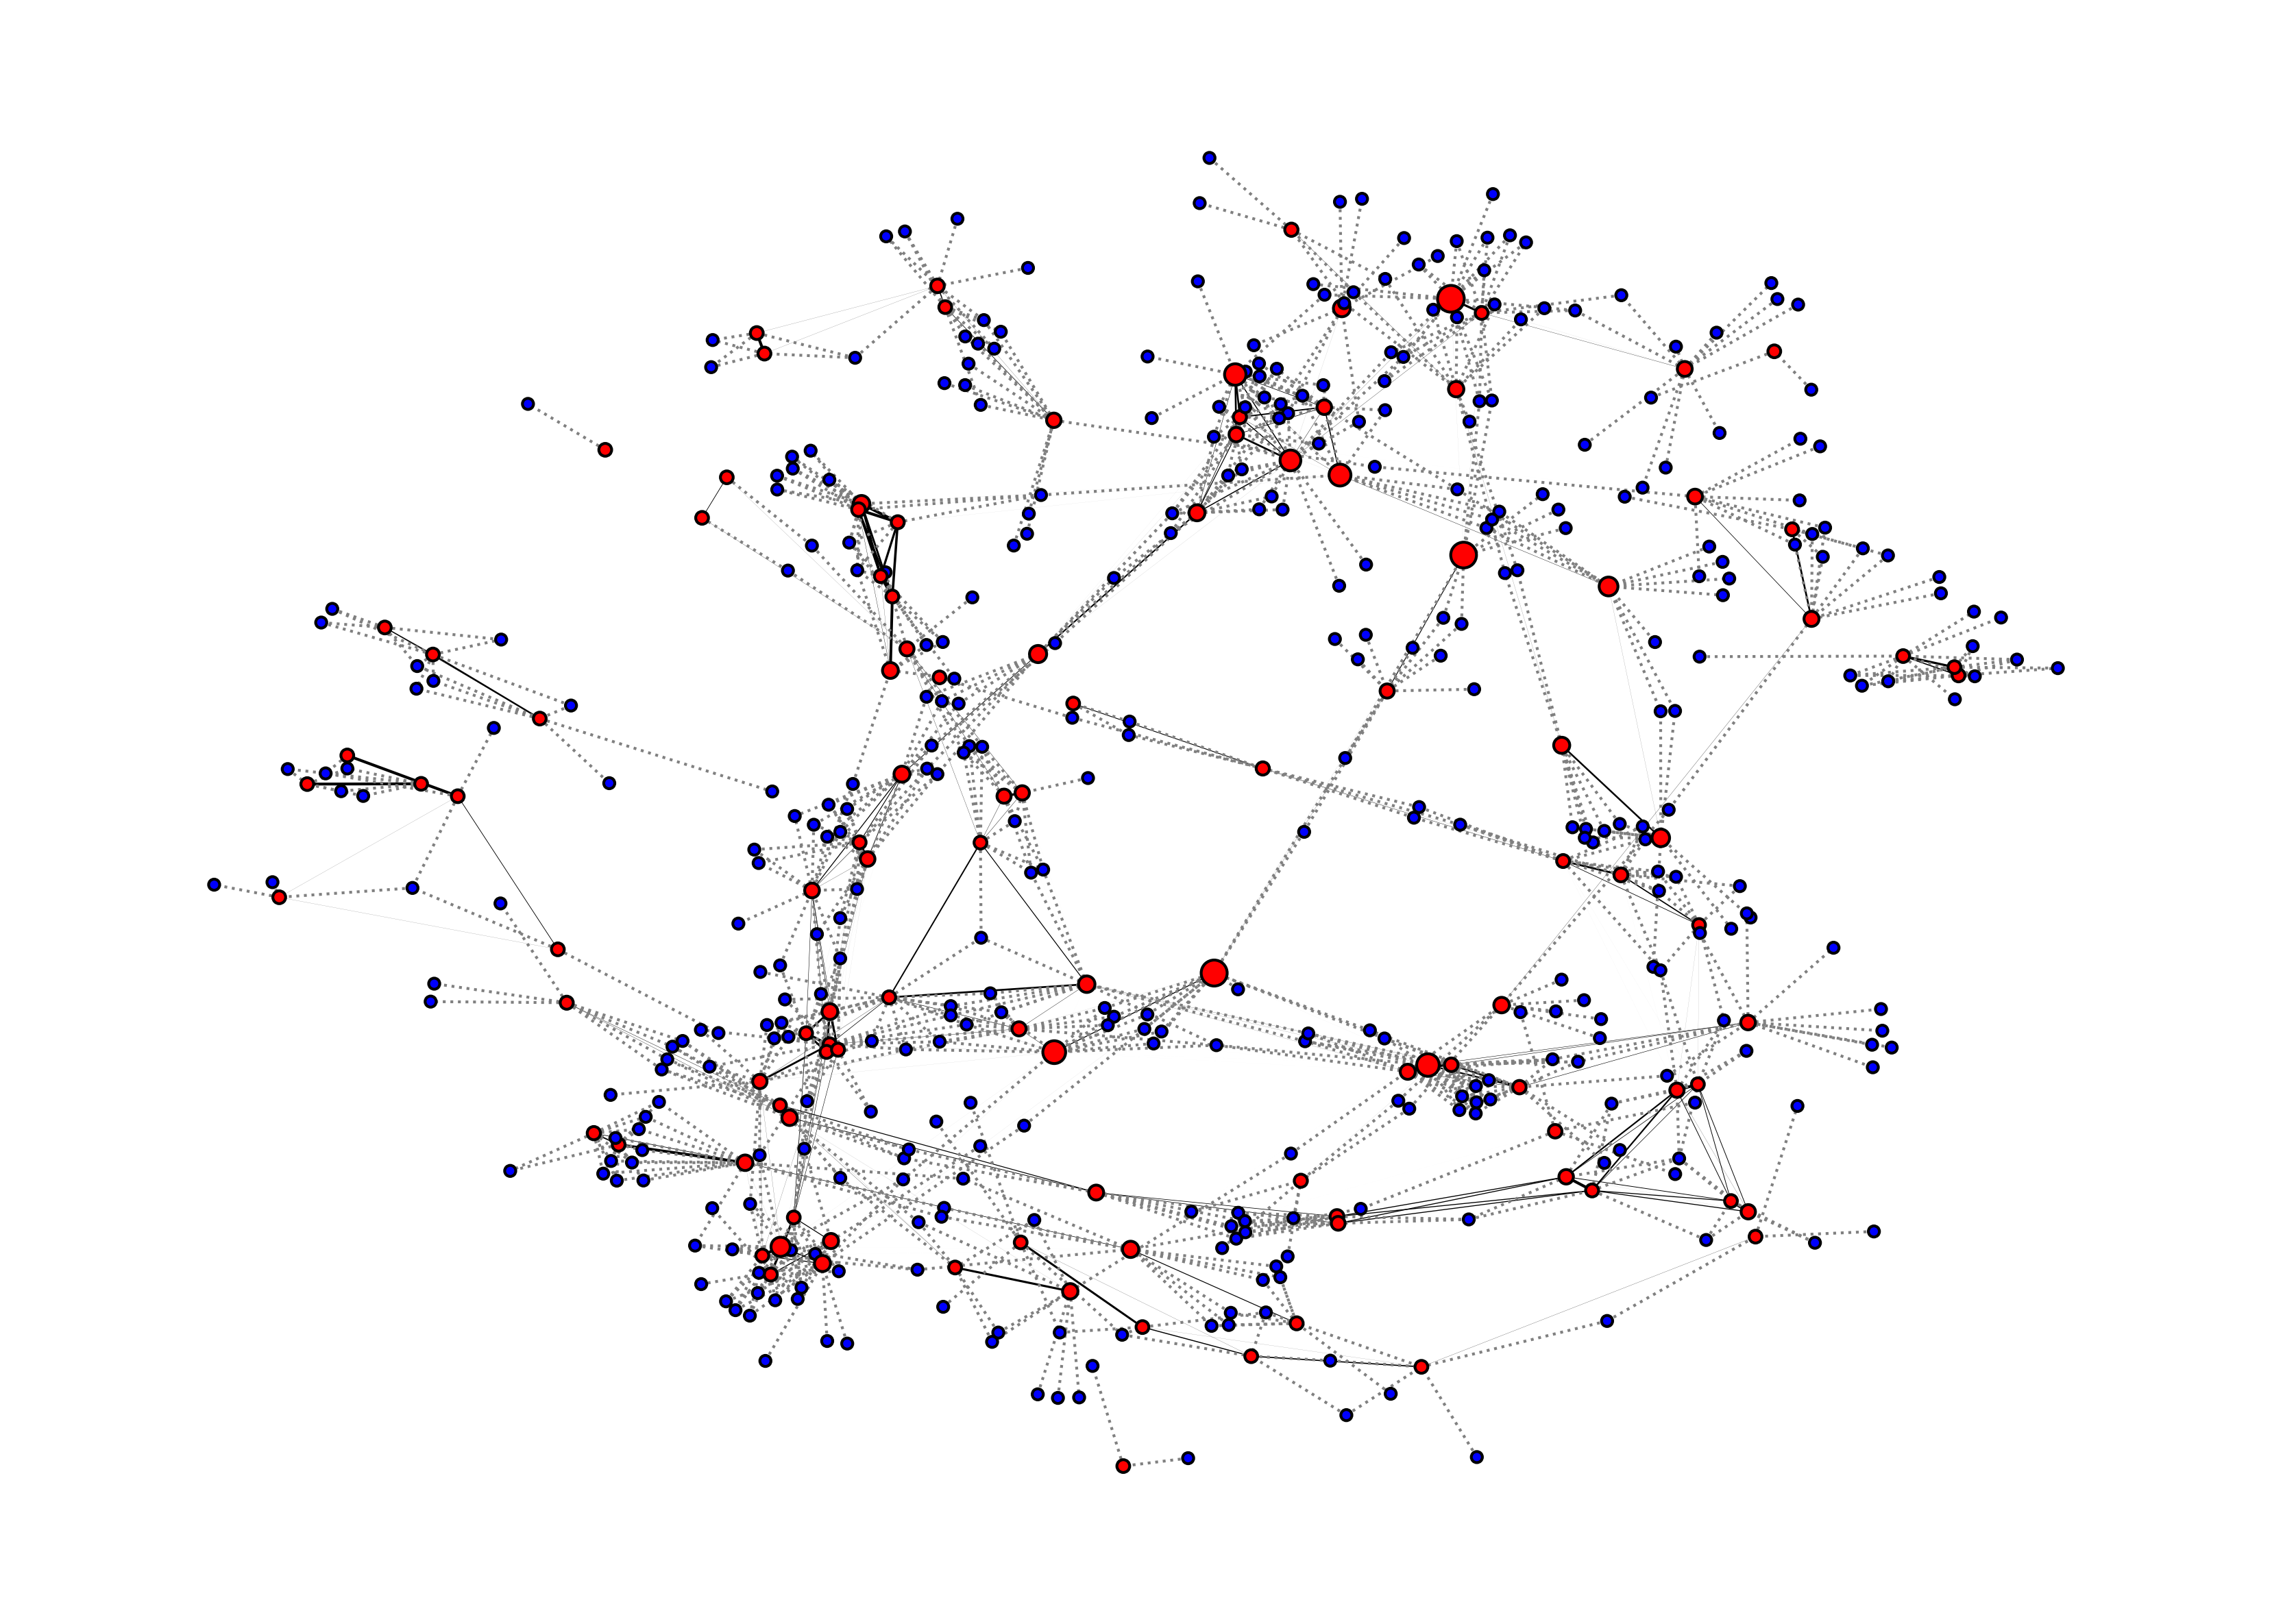

In [36]:
if bfs_nodes:
    # Subgraph for visualization
    H = G.subgraph(bfs_nodes)

    # Ensure all nodes in H have color attributes from G
    for node in H.nodes():
        if 'color' not in H.nodes[node]:
            H.nodes[node]['color'] = G.nodes[node]['color']
    
    node_colors = [H.nodes[node]['color'] for node in H.nodes()]

    # Generate spring layout for nodes
    pos = nx.spring_layout(H, seed=42, k=0.1, iterations=50)

    # Prepare the figure
    plt.figure(figsize=(14, 10), dpi = 300)
    ax = plt.gca()

    
    centrality = nx.betweenness_centrality(H, weight = 'weight')
    node_sizes = []
    for node in H.nodes():
        if H.nodes[node]['color'] == 'red':
            node_sizes.append(300 * centrality[node] + 20)  # Adjust size scaling as needed
        else:
            node_sizes.append(15)  # Keep the size constant for blue nodes

    # norm = mcolors.Normalize(vmin=min(centrality.values()), vmax=max(centrality.values()))
    # cmap = cm.get_cmap('Reds')
    # node_colors = []
    # for node in H.nodes():
    #     if H.nodes[node]['color'] == 'red':
    #         color_value = cmap(norm(centrality[node]))
    #         node_colors.append(color_value)
    #     else:
    #         node_colors.append(H.nodes[node]['color'])

    nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=node_sizes, edgecolors='k')
    
    # Draw edges with different styles and widths based on effect
    for style in ['solid', 'dotted']:
        edges = [(u, v) for u, v, d in H.edges(data=True) if d['style'] == style]
        widths = [d['weight'] for u, v, d in H.edges(data=True) if d['style'] == style]
        colors = [d['color'] for u, v, d in H.edges(data=True) if d['style'] == style]
        nx.draw_networkx_edges(H, pos, edgelist=edges, width=widths, edge_color=colors, style=style)

    

    # Draw edge labels
    # edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in H.edges(data=True) if 'weight' in d}
    # nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='red', font_size=8)

    # Draw node labels
    # nx.draw_networkx_labels(H, pos, font_size=8, font_weight='bold')

    # Title and display
    # plt.title('Sample Graph of Stores and Communities', fontsize=16)
    plt.axis('off')
    plt.savefig('network_formation_effect.pdf', format='pdf', bbox_inches='tight', dpi = 300)
    plt.show()
else:
    print("No connected stores available for visualization.")

In [21]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)


In [22]:
degree_centrality_values = list(degree_centrality.values())
betweenness_centrality_values = list(betweenness_centrality.values())
closeness_centrality_values = list(closeness_centrality.values())

avg_degree_centrality = sum(degree_centrality_values) / len(degree_centrality_values)
avg_betweenness_centrality = sum(betweenness_centrality_values) / len(betweenness_centrality_values)
avg_closeness_centrality = sum(closeness_centrality_values) / len(closeness_centrality_values)

print(f'Average Degree Centrality: {avg_degree_centrality}')
print(f'Average Betweenness Centrality: {avg_betweenness_centrality}')
print(f'Average Closeness Centrality: {avg_closeness_centrality}')

Average Degree Centrality: 0.00018591802341365394
Average Betweenness Centrality: 1.4086838884673205e-06
Average Closeness Centrality: 0.0008350910951703176


In [27]:
local_clustering = nx.clustering(G)
# print("Local Clustering Coefficient:", local_clustering)

average_clustering = nx.average_clustering(G)
print("Average Clustering Coefficient:", average_clustering)

global_clustering = nx.transitivity(G)
print("Global Clustering Coefficient:", global_clustering)

Average Clustering Coefficient: 0.26729921516495114
Global Clustering Coefficient: 0.3846081750764436
